<a href="https://colab.research.google.com/github/JakaxKato/JakaKelana_1103223048_MidTerm_MLDL/blob/main/Task1_FraudDetection_ML/fraud_detection_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import auc, accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


## Load Dataset

In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/Deeplearning/train_transaction.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/Deeplearning/test_transaction.csv")

TARGET_COL = "isFraud"
ID_COL = "TransactionID"

X = train_df.drop(columns=[TARGET_COL, ID_COL])
y = train_df[TARGET_COL]
X_test = test_df.drop(columns=[ID_COL])
test_ids = test_df[ID_COL]

print("Train shape:", X.shape)
print("Test shape:", X_test.shape)


Train shape: (590540, 392)
Test shape: (506691, 392)


## Distribusi Target

Jumlah masing-masing kelas isFraud:
isFraud
0    569877
1     20663
Name: count, dtype: int64

Proporsi masing-masing kelas isFraud:
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


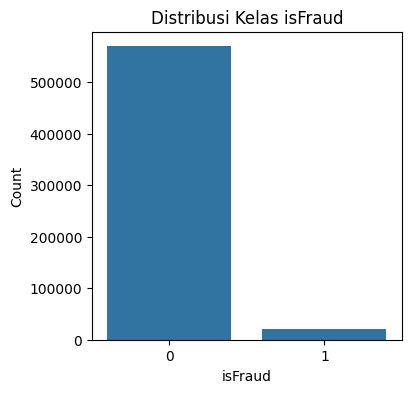

In [4]:
TARGET_COL = "isFraud"
ID_COL     = "TransactionID"

fraud_counts = train_df[TARGET_COL].value_counts()
fraud_ratio  = train_df[TARGET_COL].value_counts(normalize=True)

print("Jumlah masing-masing kelas isFraud:")
print(fraud_counts)
print("\nProporsi masing-masing kelas isFraud:")
print(fraud_ratio)

plt.figure(figsize=(4,4))
sns.countplot(x=TARGET_COL, data=train_df)
plt.title("Distribusi Kelas isFraud")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()


Sampling

In [5]:
N_SAMPLE = 30_000

if len(train_df) > N_SAMPLE:
    train_sample = train_df.sample(
        n=N_SAMPLE,
        random_state=42
    ).reset_index(drop=True)
else:
    train_sample = train_df.copy()

print("Original train shape:", train_df.shape)
print("Sampled train shape :", train_sample.shape)

print(train_sample[TARGET_COL].value_counts())
print(train_sample[TARGET_COL].value_counts(normalize=True))


Original train shape: (590540, 394)
Sampled train shape : (30000, 394)
isFraud
0    28926
1     1074
Name: count, dtype: int64
isFraud
0    0.9642
1    0.0358
Name: proportion, dtype: float64


In [6]:
y = train_sample[TARGET_COL]
X = train_sample.drop(columns=[TARGET_COL, ID_COL])

test_ids = test_df[ID_COL]
X_test   = test_df.drop(columns=[ID_COL])

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Jumlah fitur numerik    :", len(numeric_features))
print("Jumlah fitur kategorikal:", len(categorical_features))


Jumlah fitur numerik    : 378
Jumlah fitur kategorikal: 14


Train-test split

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2,
    stratify=y, random_state=42
)


Preprocessing (Imputer + Encoder)

In [8]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


## Random Forest

In [9]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf_model)
])

rf_pipeline.fit(X_train, y_train)
rf_pred_prob = rf_pipeline.predict_proba(X_valid)[:, 1]
rf_pred = (rf_pred_prob > 0.5).astype(int)

rf_auc = roc_auc_score(y_valid, rf_pred_prob)
rf_acc = accuracy_score(y_valid, rf_pred)
print("Random Forest AUC:", rf_auc)
print("Random Forest ACC:", rf_acc)


Random Forest AUC: 0.8703041144901611
Random Forest ACC: 0.9725


# Evaluasi Random Forest

In [10]:
y_valid_proba_rf = rf_pipeline.predict_proba(X_valid)[:, 1]
y_valid_pred_rf  = (y_valid_proba_rf > 0.5).astype(int)

print("=== Random Forest (Sampled Data) ===")
print("ROC-AUC:", roc_auc_score(y_valid, y_valid_proba_rf))
print("\nClassification Report:")
print(classification_report(y_valid, y_valid_pred_rf))


=== Random Forest (Sampled Data) ===
ROC-AUC: 0.8703041144901611

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5785
           1       0.87      0.27      0.42       215

    accuracy                           0.97      6000
   macro avg       0.92      0.64      0.70      6000
weighted avg       0.97      0.97      0.97      6000



In [11]:
# Ambil preprocessor & model dari pipeline yang sudah dilatih
preprocessor = rf_pipeline.named_steps["preprocessor"]
rf_model     = rf_pipeline.named_steps["model"]

batch_size = 30_000
all_proba  = []

n_test = len(X_test)
print("Total test rows:", n_test)

for start in range(0, n_test, batch_size):
    end = min(start + batch_size, n_test)
    print(f"Processing rows {start} to {end}...")

    X_batch = X_test.iloc[start:end]

    # transform batch
    X_batch_trans = preprocessor.transform(X_batch)

    # prediksi probabilitas fraud untuk batch ini
    proba_batch = rf_model.predict_proba(X_batch_trans)[:, 1]

    all_proba.extend(proba_batch)

len(all_proba)


Total test rows: 506691
Processing rows 0 to 30000...
Processing rows 30000 to 60000...
Processing rows 60000 to 90000...
Processing rows 90000 to 120000...
Processing rows 120000 to 150000...
Processing rows 150000 to 180000...
Processing rows 180000 to 210000...
Processing rows 210000 to 240000...
Processing rows 240000 to 270000...
Processing rows 270000 to 300000...
Processing rows 300000 to 330000...
Processing rows 330000 to 360000...
Processing rows 360000 to 390000...
Processing rows 390000 to 420000...
Processing rows 420000 to 450000...
Processing rows 450000 to 480000...
Processing rows 480000 to 506691...


506691

## ROC Curve & Precision–Recall Curve

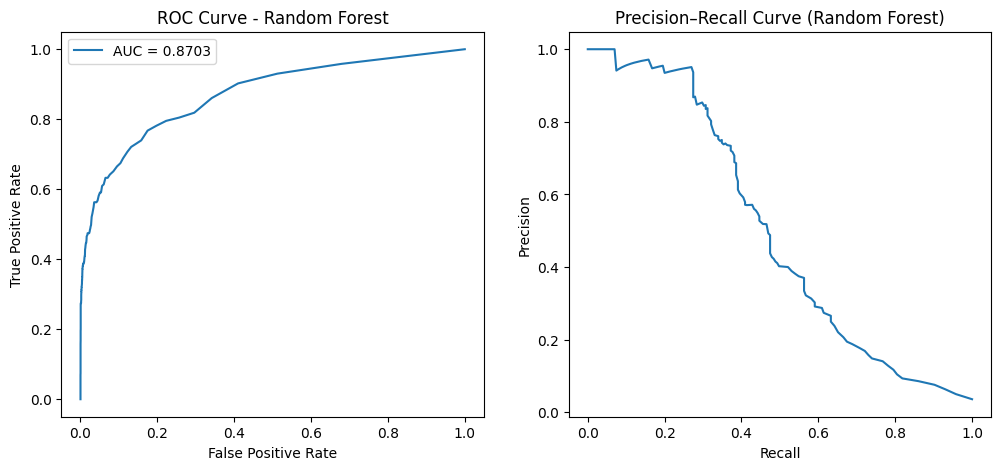

In [12]:
fpr, tpr, _ = roc_curve(y_valid, rf_pred_prob)
prec, rec, _ = precision_recall_curve(y_valid, rf_pred_prob)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {rf_auc:.4f}")
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec)
plt.title("Precision–Recall Curve (Random Forest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


## Preprocessing untuk Deep learning

In [13]:
# Fit preprocessor if not fitted
if not hasattr(preprocessor, "transformers_"):
    preprocessor.fit(X_train)

# Transform
X_train_proc = preprocessor.transform(X_train)
X_valid_proc = preprocessor.transform(X_valid)

# Scale for DL
scaler = StandardScaler()
X_train_dl = scaler.fit_transform(X_train_proc)
X_valid_dl = scaler.transform(X_valid_proc)

print("DL train shape:", X_train_dl.shape)
print("DL valid shape:", X_valid_dl.shape)


DL train shape: (24000, 392)
DL valid shape: (6000, 392)


## Deep learning model (MLP classier)

In [14]:
n_features = X_train_dl.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_shape=(n_features,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name="auc")]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       100,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,825 (554.00 KB)

 Trainable params: 141,825 (554.00 KB)

 Non-trainable params: 0 (0.00 B)

## callback + Training

In [15]:
es = EarlyStopping(
    monitor='val_auc',
    patience=3,
    mode='max',
    restore_best_weights=True
)

lr = ReduceLROnPlateau(
    monitor='val_auc',
    patience=2,
    factor=0.5,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

history = model.fit(
    X_train_dl, y_train,
    validation_data=(X_valid_dl, y_valid),
    epochs=20,
    batch_size=1024,
    callbacks=[es, lr],
    verbose=1
)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.9039 - auc: 0.5116 - loss: 0.3236 - val_accuracy: 0.9643 - val_auc: 0.8069 - val_loss: 0.1351 - learning_rate: 0.0010
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9666 - auc: 0.8040 - loss: 0.1273 - val_accuracy: 0.9673 - val_auc: 0.8255 - val_loss: 0.1209 - learning_rate: 0.0010
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9687 - auc: 0.8412 - loss: 0.1177 - val_accuracy: 0.9680 - val_auc: 0.8308 - val_loss: 0.1168 - learning_rate: 0.0010
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9713 - auc: 0.8511 - loss: 0.1060 - val_accuracy: 0.9693 - val_auc: 0.8396 - val_loss: 0.1152 - learning_rate: 0.0010
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9696 - auc: 0.8645 - loss: 0.1096 - val_accuracy: 0.9700 - val_auc: 0.8363 - val_loss: 0.1155 - learning_rate: 0.0010
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9717 - auc: 0.8741 - los

## Evaluate DL Model

In [16]:
y_pred_prob_dl = model.predict(X_valid_dl).ravel()
y_pred_dl = (y_pred_prob_dl > 0.5).astype(int)

dl_auc = roc_auc_score(y_valid, y_pred_prob_dl)
dl_acc = accuracy_score(y_valid, y_pred_dl)

print("DL AUC:", dl_auc)
print("DL ACC:", dl_acc)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
DL AUC: 0.85104540612249
DL ACC: 0.969


## Comparison ml / dl

In [17]:
print("=== MODEL COMPARISON ===")
print(f"Random Forest AUC : {rf_auc:.4f}")
print(f"Deep Learning AUC : {dl_auc:.4f}\n")

print(f"Random Forest ACC : {rf_acc:.4f}")
print(f"Deep Learning ACC : {dl_acc:.4f}")


=== MODEL COMPARISON ===
Random Forest AUC : 0.8703
Deep Learning AUC : 0.8510

Random Forest ACC : 0.9725
Deep Learning ACC : 0.9690


## Submission

In [18]:
submission = pd.DataFrame({
    "TransactionID": test_ids,
    "isFraud": all_proba
})

# Simpan langsung ke Google Drive biar aman
submission_path = "/content/drive/MyDrive/Deeplearning/submission_rf_batched.csv"
submission.to_csv(submission_path, index=False)

print("Submission disimpan sebagai:", submission_path)
submission.head()


Submission disimpan sebagai: /content/drive/MyDrive/Deeplearning/submission_rf_batched.csv


,TransactionID,isFraud
0,3663549,0.005
1,3663550,0.005
2,3663551,0.030
3,3663552,0.015
4,3663553,0.005
